In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame = False) 

In [2]:
X,y = mnist.data, mnist.target

In [3]:
X.shape

(70000, 784)

In [4]:
import matplotlib.pyplot as plt

def plot_image(image):
    image = image.reshape(28,28)
    plt.imshow(image,cmap = "binary")
    plt.axis("off")


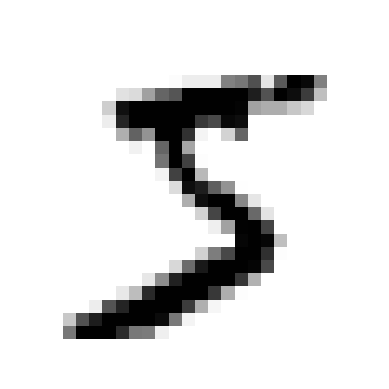

In [5]:
some_digit = X[0]
plot_image(some_digit)

In [6]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Binary classifier:

In [7]:
y_train_5 = y_train == '5'
y_test_5 = y_test == '5'
y_train_5

array([ True, False, False, ...,  True, False, False])

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_classifier  = SGDClassifier(random_state= 42)
sgd_classifier.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_classifier.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier,X_train,y_train_5, cv = 3,scoring = "accuracy")



array([0.95035, 0.96035, 0.9604 ])

The DummyClassifier classifies every single image in the most frequent class, wich in this case is the non five's

In [11]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier()

dummy_classifier.fit(X_train,y_train_5)

DummyClassifier()

In [12]:
print(any(dummy_classifier.predict(X_train)))

False


In [13]:
cross_val_score(dummy_classifier,X_train,y_train_5,cv = 3, scoring = "accuracy")

array([0.90965, 0.90965, 0.90965])

This is simply because only about 10% of the dataset are 5s, so if you guess always that an image is not a five, you will be right about 90% of the time

A much better way to evaluate the perfomance of a classifier is to lookm at the confusion matrix (CM)

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_classifier,X_train,y_train_5,cv = 3)

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred = y_train_predict, y_true = y_train_5)
cm

array([[53892,   687],
       [ 1891,  3530]])

The first row is the non 5s, 53892 were correctly classified as non 5s (True negatives), while 687 were classified wrongly as 5s (False positives)

The first row is the class of 5s, 1891 were wrongly classified as non 5s (False negative) and 3530 correctly classified as non 5s (True positives)

PRECISION AND RECALL

In [16]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_predict)

0.8370879772350012

In [17]:
recall_score(y_train_5,y_train_predict)

0.6511713705958311

Incresing precision reduces recall, and vice versa. (Precision/recall trade off)

In [18]:
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_prediction = y_scores > threshold
y_some_digit_prediction

array([ True])

In [20]:
threshold = 3000
y_some_digit_prediction = y_scores > threshold
y_some_digit_prediction

array([False])

Raising the threshold increases recall and decreases precision

In [21]:
y_scores = cross_val_predict(sgd_classifier,X_train,y_train_5,cv = 3, method = "decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

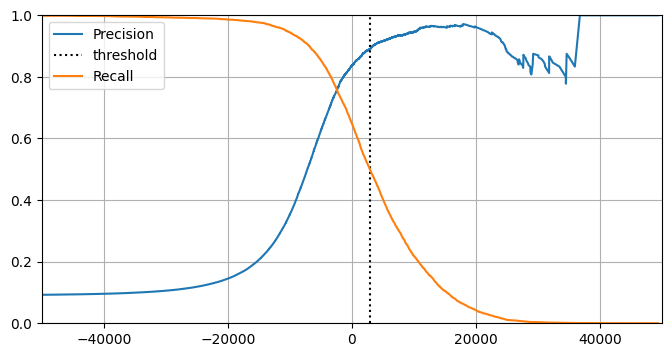

In [23]:
plt.figure(figsize = (8,4))
plt.plot(thresholds,precisions[:-1], label = "Precision")
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.plot(thresholds,recalls[:-1], label =  "Recall")
plt.axis([-50000,50000,0,1])
plt.grid(True)
plt.legend()
plt.savefig(fname = "precision-recall-thresholds")
plt.show()

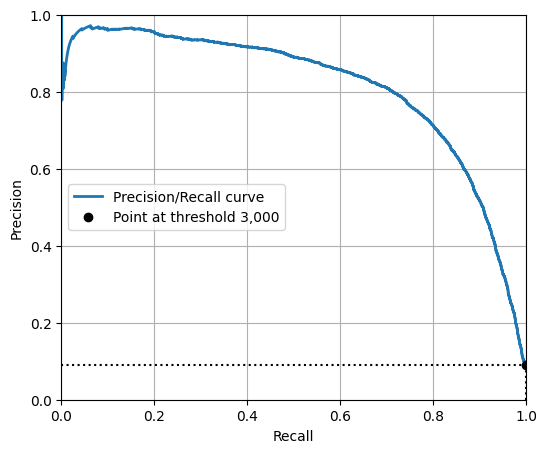

In [62]:
import matplotlib.patches as patches  # extra code – for the curved arrow

idx = (thresholds >= threshold).argmax()

plt.figure(figsize=(6, 5)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.axis([0,1,0,1])
plt.grid(True)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.savefig("Precision versus recall SGDClassifier")
plt.show()

We are seeking for 90% precision. We can search for the lowest threshold that gives at least 90%

In [24]:
idx_for_90 = (precisions >= 0.9).argmax()
threshold_for_90 = thresholds[idx_for_90]
threshold_for_90

np.float64(3370.019499143956)

In [25]:
y_pred_90 = y_scores >= threshold_for_90

In [26]:
precision_score(y_train_5,y_pred_90)

0.9000345901072293

In [27]:
recall_at_90 = recall_score(y_train_5,y_pred_90)
recall_at_90

0.4799852425751706

The ROC curve plots the FPR (False positive rate) versus TNR (True negative rate)

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr,thresholds = roc_curve(y_train_5,y_scores)

In [34]:
index_for_threshold_at_90 = (thresholds <= threshold_for_90).argmax()

tpr_90, fpr_90 = tpr[index_for_threshold_at_90] , fpr[index_for_threshold_at_90]

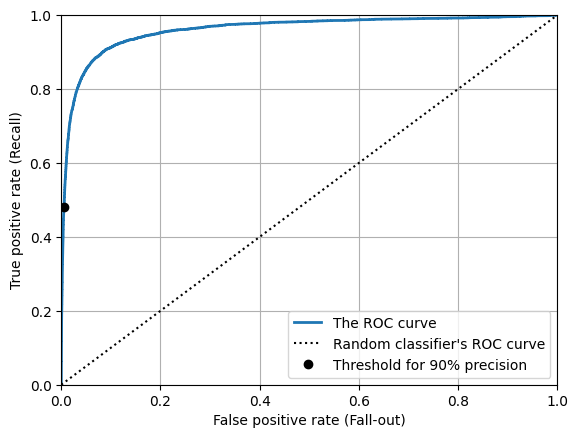

In [63]:
plt.plot(fpr,tpr,linewidth = 2,label = "The ROC curve")
plt.plot([0,1],[0,1],'k:', label = "Random classifier's ROC curve")
plt.plot([fpr_90],[tpr_90], 'ko',label = "Threshold for 90% precision")
plt.xlabel("False positive rate (Fall-out)")
plt.ylabel("True positive rate (Recall)")
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.savefig("TPR versus FPR of the SGDClassifier")
plt.show()

A good classifier has a curve as far as possible from the dotted one, because she represents a roc curve for a random classifier

AUC (Area under the curve)

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

np.float64(0.9604938554008616)

Now, using a RandomForestClassifier:

In [46]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state = 42)

In [47]:
y_probas_forest_classifier = cross_val_predict(forest_classifier,X_train,y_train_5,cv = 3,method = "predict_proba")

In [48]:
y_probas_forest_classifier[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [50]:
y_scores_forest = y_probas_forest_classifier[:, 1]

precision_forest, recall_forest,thresholds_forest = precision_recall_curve(y_train_5,y_scores_forest)

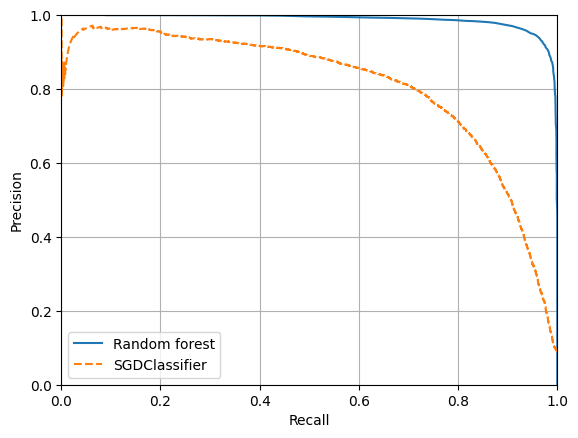

In [69]:
plt.plot(precision_forest,recall_forest, label = "Random forest")
plt.plot(recalls, precisions,"--" ,label = "SGDClassifier")
plt.legend()
plt.grid()
plt.axis([0,1,0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig("Comparison between RandomForest and SGDClassifier (PR Curve)")
plt.show()

In [80]:
y_pred_forest = y_probas_forest_classifier[: , 1].round() == True
y_pred_forest


array([ True, False, False, ...,  True, False, False])

In [81]:
prec_forest , recall_for = precision_score(y_train_5,y_pred_forest), recall_score(y_train_5,y_pred_forest)

In [83]:
print(f"Precision: {prec_forest}")
print(f"Recall: {recall_for}")

Precision: 0.9905083315756169
Recall: 0.8662608374838591
